# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# загрузим библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
display(labels.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
5783,005783.jpg,21
658,000658.jpg,18
3673,003673.jpg,35


In [3]:
# размер выборки, статистика
display(labels.shape)
labels.describe()

(7591, 2)

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


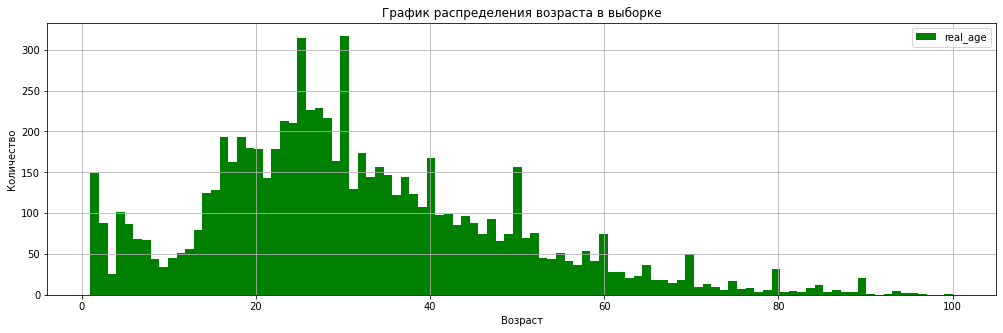

In [4]:
# график распределения возраста в выборке
labels.plot(kind='hist',figsize=(17,5),bins=100, grid=True, color='g')
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Found 7591 validated image filenames.


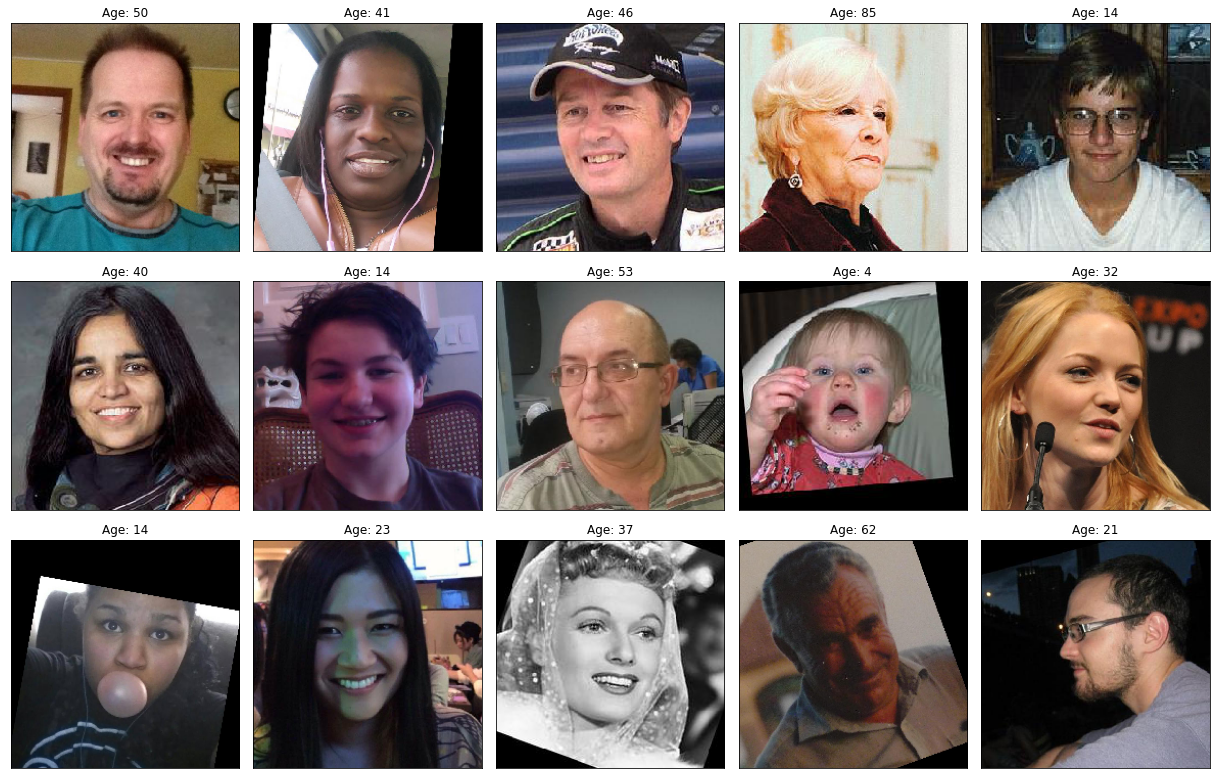

In [5]:
# выведем 15 фото
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12345)
features, target = next(gen_flow)

fig = plt.figure(figsize=(17,11))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

* `7591` фотографий;
* Основная часть в диапазоне: `20`- `41` лет;
* Есть дети и старики: пик на возрасте до `10` лет;
* Распределение по возрастам выглядит нормальным;
* Присутствуют объекты, которые закрывают лицо: рука, наушники, микрофон, жвачка, очки, головной убор и т.д., что может стать помехой.

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 



```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 66s - loss: 207.5147 - mae: 10.9697 - val_loss: 473.2211 - val_mae: 16.6884
Epoch 2/20
356/356 - 39s - loss: 141.7336 - mae: 9.1434 - val_loss: 441.9200 - val_mae: 16.8475
Epoch 3/20
356/356 - 39s - loss: 118.8890 - mae: 8.2713 - val_loss: 225.1975 - val_mae: 10.6345
Epoch 4/20
356/356 - 39s - loss: 98.2903 - mae: 7.6003 - val_loss: 154.3479 - val_mae: 9.1102
Epoch 5/20
356/356 - 39s - loss: 83.9918 - mae: 7.0582 - val_loss: 145.9961 - val_mae: 9.1142
Epoch 6/20
356/356 - 39s - loss: 72.5862 - mae: 6.5198 - val_loss: 161.4335 - val_mae: 9.3666
Epoch 7/20
356/356 - 39s - loss: 64.7623 - mae: 6.1600 - val_loss: 97.9110 - val_mae: 7.3949
Epoch 8/20
356/356 - 39s - loss: 55.0251 - mae: 5.6712 - val_loss: 150.9888 - val_mae: 9.7506
Epoch 9/20
356/356 - 39s - loss: 44.9805 - mae: 5.1777 - val_loss: 106.0146 - val_mae: 7.7164
Epoch 10/20
356/356 - 39s - loss: 37.9752 - mae: 4.7608 - val_loss: 99.9510 - val_mae: 7.3815
Epoch 11/20
356/356 - 39s - loss: 37.4652 - mae: 4.6789 - val_loss: 123.8711 - val_mae: 8.1923
Epoch 12/20
356/356 - 39s - loss: 32.7699 - mae: 4.4018 - val_loss: 128.1091 - val_mae: 8.2561
Epoch 13/20
356/356 - 39s - loss: 26.5233 - mae: 3.9544 - val_loss: 83.4666 - val_mae: 6.7139
Epoch 14/20
356/356 - 39s - loss: 23.1180 - mae: 3.7011 - val_loss: 85.2426 - val_mae: 6.8961
Epoch 15/20
356/356 - 39s - loss: 20.4705 - mae: 3.4873 - val_loss: 85.8044 - val_mae: 6.9999
Epoch 16/20
356/356 - 39s - loss: 21.1172 - mae: 3.5131 - val_loss: 100.5199 - val_mae: 7.8316
Epoch 17/20
356/356 - 39s - loss: 23.6321 - mae: 3.7561 - val_loss: 84.0004 - val_mae: 6.8685
Epoch 18/20
356/356 - 39s - loss: 22.4977 - mae: 3.6567 - val_loss: 87.1268 - val_mae: 7.0112
Epoch 19/20
356/356 - 39s - loss: 18.8073 - mae: 3.3487 - val_loss: 87.3915 - val_mae: 6.8651
Epoch 20/20
356/356 - 39s - loss: 17.5730 - mae: 3.2327 - val_loss: 79.9004 - val_mae: 6.6661
  ...
    to  
  ['...']
119/119 - 10s - loss: 79.9004 - mae: 6.6661
Test MAE: 6.6661

```

## Анализ обученной модели

Построена и обучена свёрточная нейронная сеть на датасете с фотографиями людей:
* Модель построена на основе архитектуры свёрточной нейросети `ResNet50`, обученная более чем на миллионе изображений от базы данных `ImageNet`;
* Выполнена аугментация изображений: отражение по горизонтали;
* Использованы слои:
* * `GlobalAveragePooling2D` для усреднения информации по всему изображению,
* * `Dense` - полносвязанный слой с одним нейроном и функцией активации `ReLU`.
* Применён алгоритм `Adam` со скоростью обучения `0.0005` .
* Функция потерь `MSE` для ускорения обучения.
* Модель обучалась на 20 эпохах.
Значение метрики `MAE` на тестовой выборке: `6.6661` , поставленная задача выполнена.